<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

## imports

In [2]:
import numpy
import pandas 

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [3]:
# configurations
config_dict = { 'analysis_start_year'  : 2021
              , 'analysis_start_month' : 1
              , 'analysis_end_year'    : 2021
              , 'analysis_end_month'   : 2
              , 'analysis_country'     : 'US' }


# seed topics
topics = ['flipflops', 'pumpkin', 'turkey', 'baseball', 'basketball', 'football', 'kite', 'ice cream', 'hotdog', 'rocket', 'fireworks', 'pizza', 'bbq', 'parade']



In [4]:
# for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # add column for new topic
    df_total[topic] = df[topic]

  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [5]:
df_total = get_trend_frame(topics, '5')


In [6]:
# capture features
df_features = df_total[topics]

# normalize
df_features=(df_features-df_features.mean())/df_features.std()

In [27]:

# normalize it all history (meanly)
df_total = (df_total-df_total.mean())/df_total.std()
df_features_recent = df_total[df_total.index > '1/1/2010']

# normalize it recent history (meanly)
df_features_recent = (df_features_recent-df_features_recent.mean())/df_features_recent.std()

# group by week, average occurences
df_agg = df_features
df_agg_recent = df_features_recent


In [28]:
# populate us
df_stk=pandas.DataFrame()
globalst=[]

# navigate hierarchy, each combination of WEEKNUM and FLOWER
for col in df_agg:           # flower
    for val in df_agg.index.weekofyear: # weeknum
        
        
        # time sensitive
        fs_val = df_agg[col][val]                   # full spectrum
        
        # in cases of no recent
        try:
            fs_val_recent = df_agg_recent[col][val] # recent spectrum
        except:
            fs_val_recent = 0
        
        
        # at this combo of flower/weeknum, check which source is greater, as its our limiter
        if fs_val > fs_val_recent:
            fs_max = fs_val
            fs_min = fs_val_recent
            fs_max_src = 'full'
        else:
            fs_max = fs_val_recent
            fs_min = fs_val
            fs_max_src = 'recent'
        
        
        # if max frequency signal greater than 0
        #if fs_max > 0 or fs_min > 0:
        #if fs_max > 0:
        if fs_max > 0.1 and fs_min > 0.1:
            
            # secondary source counter
            sec_i=1
            
            
            # iterate through each instance of max bin occurence, determining number of weeks written
            for x in range(0,int(abs(fs_max) * 100)):
            
            
                # full source
                if fs_max_src == 'full':
                    
                    if sec_i < int(abs(fs_min) * 100):
                    
                        lst=[val, val, col]
                        globalst.append(lst)
                    
                    else:
                        
                        lst=[val, None, col]
                        globalst.append(lst)                    
                    
                # recent source
                if sec_i < int(abs(fs_min) * 100):
                    
                    lst=[val, val, col]
                    globalst.append(lst)
                    
                else:
                        
                    lst=[None, val, col]
                    globalst.append(lst)                     
                    
                    
                sec_i+=1
                #print(sec_i)
                #print(df_agg[col][val])
                #print(df_agg_recent[col][val])
                
                
                #lst=[val, col]
                globalst.append(lst)
       
    
        #df_stk=df_stk.append(lst)

df_flat = pandas.DataFrame(globalst
                      ,columns=['WeekNum'
                               ,'WeekNum_Rct'
                               ,'Flower_Tot'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [29]:
df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()
df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]
print(df_stats.columns)
df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

#df_stats['Name'] = '00' + str((df_stats['WeekNum mean']).astype(int)) #+ df_stats['Flower']
df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

i = 1
for index, row in df_stats.iterrows():
    #print(row['Flower'], row['Name'])
    df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower'] = df_flat['Flower'].replace(row['Flower'], str(i) + row['Flower'])
    i+=1

print(df_flat)

Index(['Flower_Tot', 'WeekNum mean', 'WeekNum count', 'WeekNum_Rct mean',
       'WeekNum_Rct count'],
      dtype='object')
        WeekNum  WeekNum_Rct      Flower_Tot
0          10.0         10.0  2346 flipflops
1          10.0         10.0  2346 flipflops
2          10.0         10.0  2346 flipflops
3          10.0         10.0  2346 flipflops
4          10.0         10.0  2346 flipflops
...         ...          ...             ...
307957     52.0         52.0     4339 parade
307958     52.0         52.0     4339 parade
307959     52.0          NaN     4339 parade
307960      NaN         52.0     4339 parade
307961      NaN         52.0     4339 parade

[307962 rows x 3 columns]


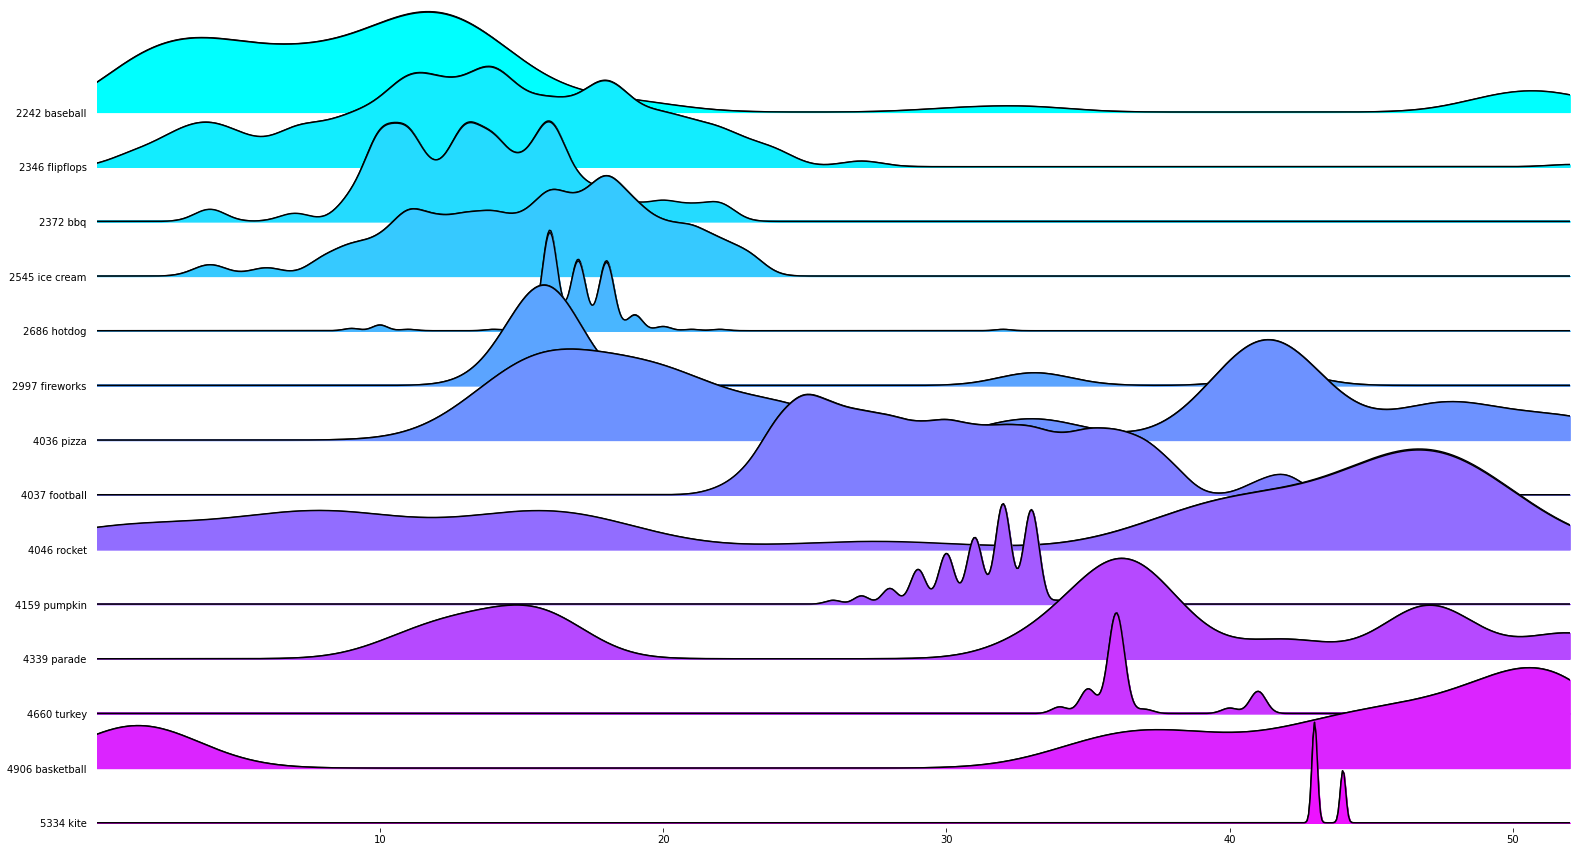

In [30]:
fig, axes = joypy.joyplot(df_flat
                          , column=['WeekNum', 'WeekNum_Rct']
                          , by='Flower_Tot'
                          , overlap=1.2
                          , fill=True
                          , figsize=(22,12)
                          , x_range = [0,52]
                          , colormap=cm.cool                         
                          , ylim='own'
                         )

plt.savefig('frank_jj.png')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe11ea7950>]],
      dtype=object)

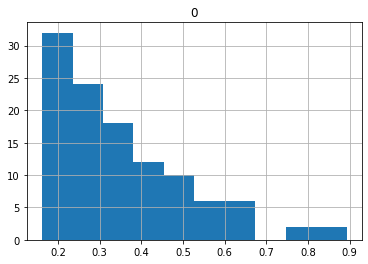

In [31]:

c = df_agg.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")



#df_slice = so[50:-13].to_frame()
#df_slice = so[:-13].to_frame()

df_slice = so[70:-len(topics)].to_frame()
df_slice.hist()

In [12]:
df_slice

0
kite      hotdog     0.162138
hotdog    kite       0.162138
          turkey     0.165943
turkey    hotdog     0.165943
pizza     hotdog     0.184236
...                       ...
flipflops baseball   0.673335
ice cream flipflops  0.759286
flipflops ice cream  0.759286
bbq       ice cream  0.892854
ice cream bbq        0.892854

[112 rows x 1 columns]

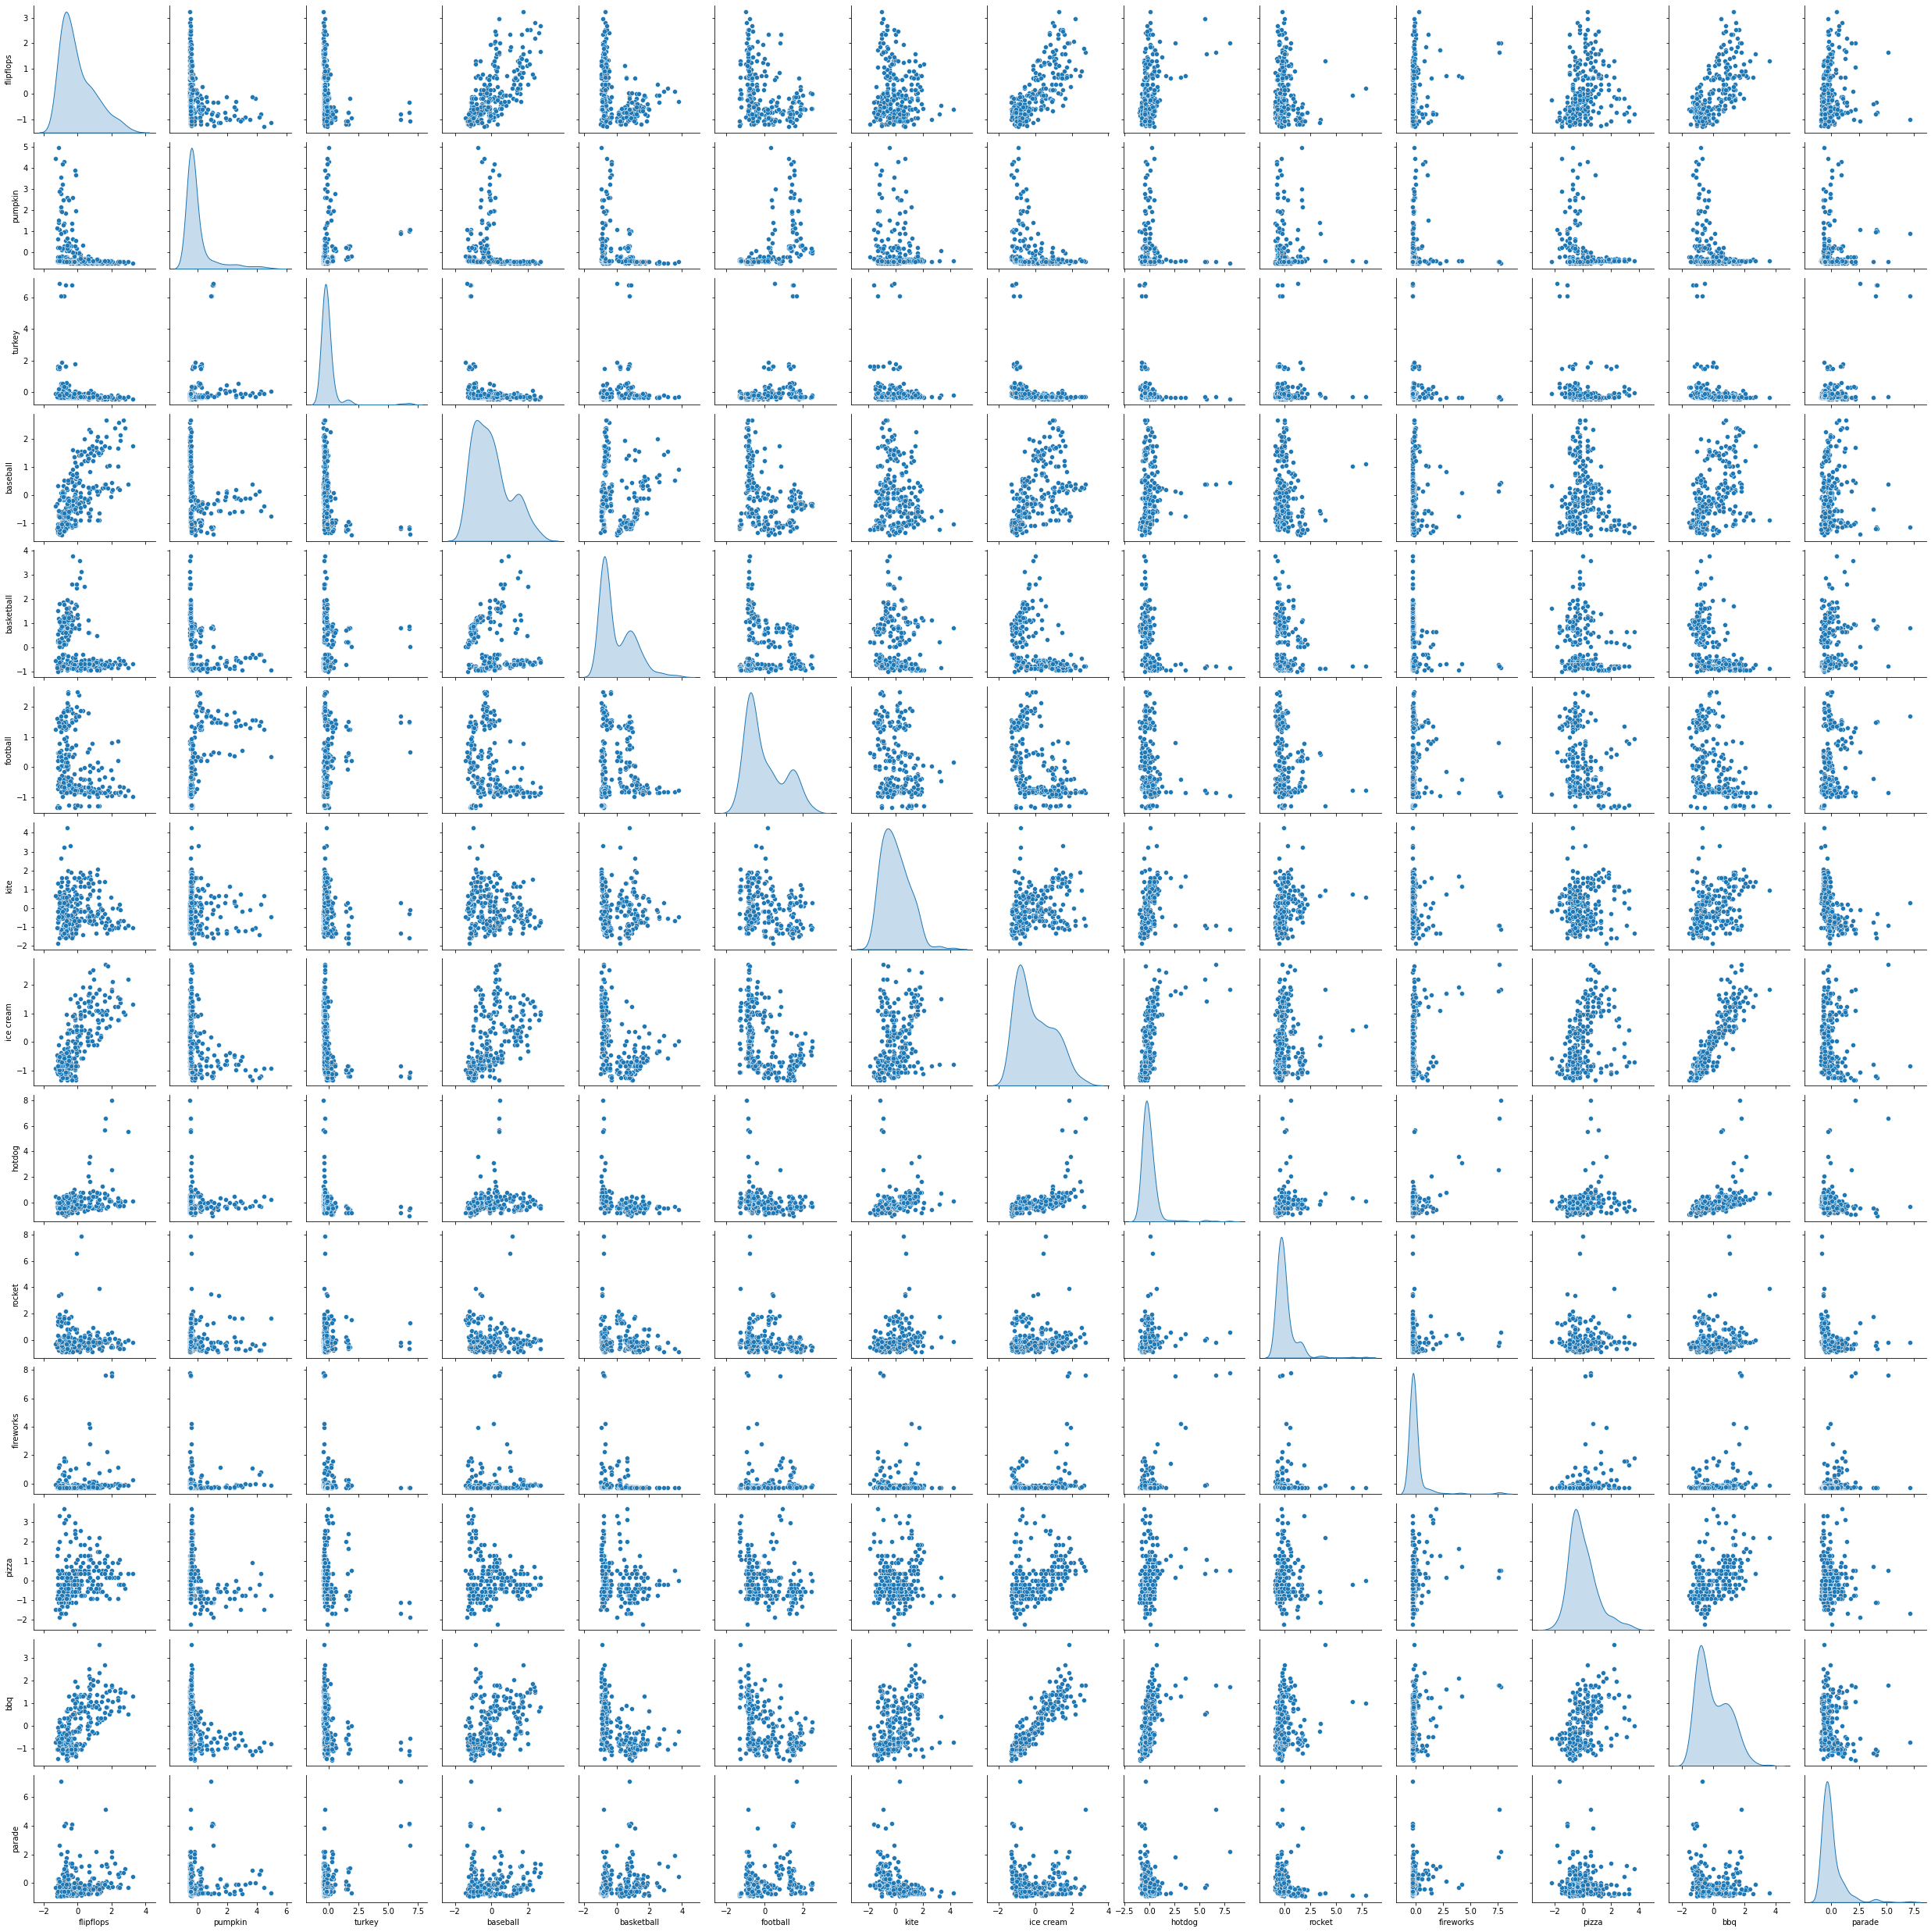

In [13]:
seaborn.pairplot(df_agg,diag_kind = 'kde',kind = 'scatter',palette = 'husl')

In [14]:
df_slice.reset_index(inplace=True)

In [15]:
df_slice.columns = ['source','target','weight']

In [16]:
df_slice['cost'] = numpy.random.randint(1, 6, df_slice.shape[0])

node degree clustering
kite 6 0.6
hotdog 9 0.7222222222222222
turkey 9 0.7222222222222222
pizza 9 0.8055555555555556
baseball 6 1.0
pumpkin 8 0.8571428571428571
rocket 3 1.0
football 11 0.5818181818181818
parade 6 0.26666666666666666
basketball 7 0.6666666666666666
bbq 11 0.6727272727272727
fireworks 6 0.6666666666666666
flipflops 10 0.7555555555555555
ice cream 11 0.6727272727272727
#/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-5a0f6152-93ff-48dc-9d91-9a022ee0f221.json
# GMT Sun Mar  6 19:58:24 2022
# 
kite hotdog rocket football ice cream bbq parade
hotdog turkey pizza football basketball flipflops bbq ice cream fireworks
turkey pizza pumpkin bbq flipflops football ice cream baseball parade
pizza basketball fireworks flipflops pumpkin football ice cream bbq
baseball pumpkin football bbq ice cream flipflops
pumpkin basketball bbq ice cream flipflops football
rocket football parade
football parade flipflops bbq ice cream
para

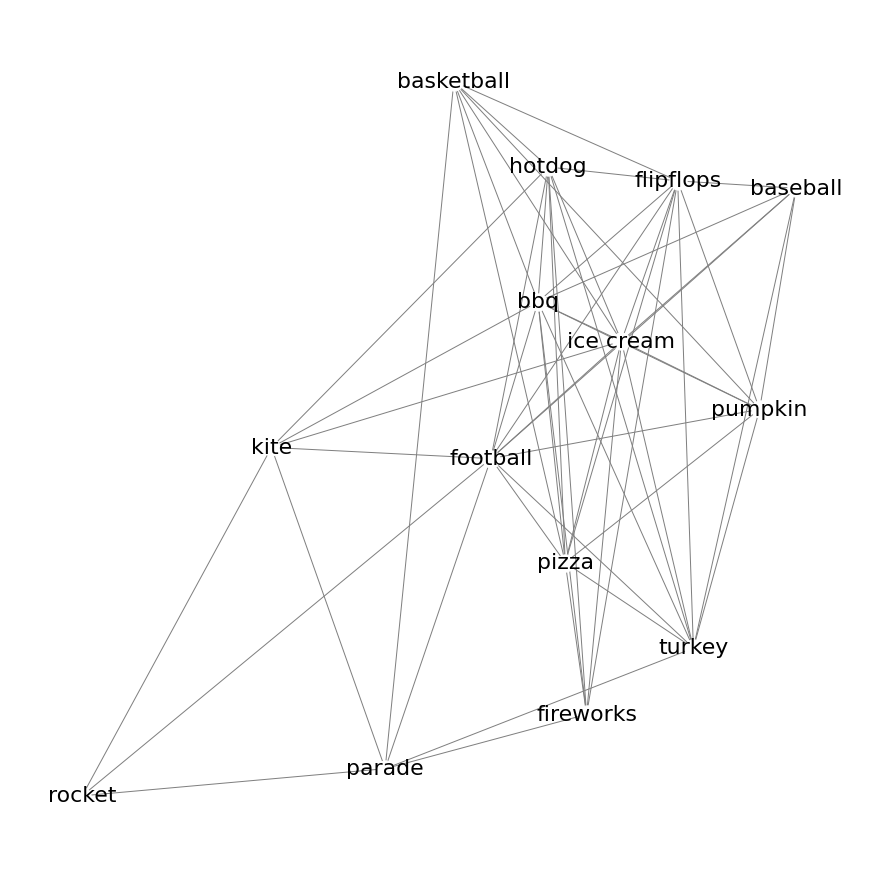

In [17]:
from networkx.algorithms.bipartite.basic import color
from networkx import *
import networkx as nx
import sys

n=10 # 10 nodes
m=20 # 20 edges

#G=gnm_random_graph(n,m)
#G=nx.from_pandas_dataframe(df_slice, 0, 'b', ['weight', 'cost'])
#G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight', 'cost'])
G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight'])


# some properties
print("node degree clustering")
for v in nodes(G):
    print(v,degree(G,v),clustering(G,v))

# print the adjacency list to terminal 
write_adjlist(G,sys.stdout)

plt.figure(3,figsize=(12,12)) 
draw(G
     ,with_labels=True
     ,edge_color='gray'
     ,node_color='white'
     ,font_size=22)


In [18]:
#df_slice.columns(["l","weight", "cost"])
G["football"]["baseball"]["weight"]


0.3778915659902189

In [19]:
# list nodes
G.nodes.items()

# edges
G.number_of_edges()

# print neighbors
for v in G.neighbors('rocket'):
  print(v)

football
parade
kite


In [20]:
# send openai question, receive response
def get_response(question):
  response = openai.Completion.create(
    engine="text-davinci-001",
    prompt=question,
    temperature=.01,
    max_tokens=250,
    top_p=1,
    frequency_penalty=50,
    presence_penalty=0
  )

  # process response
  response_choices = response["choices"]
  response_choice_text = response_choices[0]["text"]
  ''.join(e for e in response_choice_text if e.isalnum())
  response = response_choices[0]["text"].strip('\n')

  return response

In [21]:
responses = []


# retrieve 
retrieval = get_response('List similiar seasonal occurying concepts to baseball besides basketball and football and hockey and soccer')
responses.append(retrieval)

In [22]:
responses

['Volleyball, lacrosse']